In [34]:
import os
import ROOT as r

import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
    
def linear_shape(mjj,slope,level):
    return slope*mjj+level

def parabolic_shape(mjj,a,b,c):
    return a*(mjj**2)+b*mjj+c

def chi_square(model, slope, level, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-2))

def chi_square2(model, slope, level,offset, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level,offset))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-3))


def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())

    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins
            
def Unpack_Histo(histogram_file):
    bin_content = []
    bin_content_uncer =[]
    for i in range(2,histogram_file.GetNbinsX()+1+1): # overflow bin
        bin_content.append(histogram_file.GetBinContent(i))
        bin_content_uncer.append(histogram_file.GetBinError(i))
    return np.array(bin_content),np.array(bin_content_uncer)

def SR_parameters(dict_of_parameters):
    sr_dic = {}
    for i in dict_of_parameters["CRa"]:
        transfer_factor = (dict_of_parameters["CRc"][i][0]/dict_of_parameters["CRb"][i][0])
        transfer_factor_err = transfer_factor*((dict_of_parameters["CRc"][i][1]/dict_of_parameters["CRc"][i][0])**2+(dict_of_parameters["CRb"][i][1]/dict_of_parameters["CRb"][i][0])**2)**0.5
        sr_dic[i] = [dict_of_parameters["CRa"][i][0]*transfer_factor , dict_of_parameters["CRa"][i][0]*transfer_factor*((transfer_factor_err/transfer_factor)**2+(dict_of_parameters["CRa"][i][1]/dict_of_parameters["CRa"][i][0])**2)**0.5]

    return sr_dic

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
#from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)


############ Create a 2D least square fit ###################

from iminuit.util import describe, make_func_code
class LeastSquares:
    """
    Generic least-squares cost function with error.
    """

    errordef = Minuit.LEAST_SQUARES # for Minuit to compute errors correctly

    def __init__(self, model, s1, s2, y, err):
        self.model = model  # model predicts y for given x
        self.s1 = np.asarray(s1)
        self.s2 = np.asarray(s2)
        self.y = np.asarray(y)
        self.err = np.asarray(err)

    def __call__(self, *par):  # we accept a variable number of model parameters
        ym = self.model(self.s1,self.s2, *par)
        return np.sum((self.y - ym) ** 2 / self.err ** 2)
    
class BetterLeastSquares(LeastSquares):
    def __init__(self, model, s1 , s2, y, err):
        super().__init__(model, s1,s2 , y, err)
        self.func_code = make_func_code(describe(model)[2:])

iminuit version: 2.11.2


In [35]:
### Defining class to store information for fit procedure

class mjj_shape :
    def __init__(self,samples,path_to_samples,final_state,histogram="mass_jj"):
        self.final_state = final_state
        self.samples = samples
        self.path_to_samples = path_to_samples
        self.regions = [i for i in os.listdir(path_to_samples)]
        self.dic_of_samples = {}
        self.dic_of_parameters = {"SR":0.0}
        self.residuals = {}
        self.x_axis = np.array([])
        self.qcd_factors = []
        self.vbf_factors = []
        
        ### when initialising the object, fill the dictionaries with the samples shape

        for reg in self.regions:
            temp_dic ={}
            for s in samples :

                ### Open the file and get the histogram
                file = r.TFile.Open(path_to_samples+reg+'/'+s)
                hist = file.Get(histogram)
                hist.SetDirectory(0)
                ### Rebin the histogram
                rebining=biner([1500],[250,500],hist)
                nb=len(rebining)-1
                hist=hist.Rebin(nb,"hist",rebining)
                ### Unpack the histogram
                value,uncern = Unpack_Histo(hist)
                if s=="Data.root":
                    x = []
                    for b in range(2,hist.GetNbinsX()+2):
                        x.append(hist.GetBinLowEdge(b))
                    self.x_axis = np.array(x)

                temp_dic[s]={"value":value,"uncern":uncern}
                if "Signal" in s:
                    temp_dic[s+"RW"]=temp_dic[s]
            self.dic_of_samples[reg] = temp_dic
            
            

    ### function to calculate the residuals from the samples data

    def calculate_residuals(self,vbf_sample,qcd_sample):
        for reg in self.regions:
            if "CR" in reg:
                residual_val = self.dic_of_samples[reg]["Data.root"]["value"] - self.dic_of_samples[reg][vbf_sample]["value"]
                residual_err = ((self.dic_of_samples[reg]["Data.root"]["uncern"])**2 + (self.dic_of_samples[reg][vbf_sample]["uncern"])**2)**0.5
                
                for s in self.samples:
                    if  self.final_state not in s and "Data" not in s and "Signal" not in s:
                        residual_val = residual_val - self.dic_of_samples[reg][s]["value"]
                        residual_err = (residual_err**2 + (self.dic_of_samples[reg][s]["uncern"])**2)**0.5
                for i in range(0,len(residual_val)):
                    if residual_val[i]<0:
                        residual_val[i]=0
                
                uncer = ((residual_err/residual_val)**2+(self.dic_of_samples[reg][qcd_sample]["uncern"]/self.dic_of_samples[reg][qcd_sample]["value"])**2)**0.5
                residual_val = residual_val/self.dic_of_samples[reg][qcd_sample]["value"]
                residual_err = residual_val*uncer

                self.residuals[reg] = {"value":residual_val,"uncern":residual_err}

    def fit_data(self,reg):
        c = 0
        for i in self.residuals[reg]["value"]:
            if i>0:
                c+=1
            else :
                break
        return self.x_axis[0:c],self.residuals[reg]["value"][0:c],self.residuals[reg]["uncern"][0:c]
    
    def rw_sr(self,qcd_sample,model,*args):
        model_vec = np.vectorize(model)
        weights = model_vec(self.x_axis,*args)
        
        self.dic_of_samples["SR"][qcd_sample+"RW"]={"value":weights*self.dic_of_samples["SR"][qcd_sample]["value"],"uncern":self.dic_of_samples["SR"][qcd_sample]["uncern"]}
        
    def data_subtracted(self,reg):
        self.dic_of_samples[reg]["Data_Subracted"] = {"value":self.dic_of_samples[reg]["Data.root"]["value"],"uncern":self.dic_of_samples[reg]["Data.root"]["uncern"]}
        for i in self.dic_of_samples[reg]:
            if ("Data" not in i) and (self.final_state not in i) and ("Signal" not in i):
                self.dic_of_samples[reg]["Data_Subracted"]["value"]=self.dic_of_samples[reg]["Data_Subracted"]["value"] - self.dic_of_samples[reg][i]["value"]
                self.dic_of_samples[reg]["Data_Subracted"]["uncern"]=((self.dic_of_samples[reg]["Data_Subracted"]["uncern"])**2 + (self.dic_of_samples[reg][i]["uncern"])**2)**0.5
        return self.dic_of_samples[reg]["Data_Subracted"]
    
    def fit_norm(self,vbf_sample,qcd_sample):
        def model(shape1,shape2, qcd, vbf):
            return qcd*shape1 + vbf*shape2
        
        x_axis = self.x_axis
        y_axis = self.data_subtracted("SR")["value"]

        y_error = ( (self.data_subtracted("SR")["uncern"])**2 + (self.dic_of_samples["SR"][vbf_sample]["uncern"])**2 + (self.dic_of_samples["SR"][qcd_sample]["uncern"])**2 )**0.5
        qcd_shape = self.dic_of_samples["SR"][qcd_sample]["value"]
        qcd_shape_uncer = self.dic_of_samples["SR"][qcd_sample]["uncern"]

        vbf_shape = self.dic_of_samples["SR"][vbf_sample]["value"]
        vbf_shape_uncer = self.dic_of_samples["SR"][vbf_sample]["uncern"]

        least_squares = BetterLeastSquares(model,qcd_shape,vbf_shape, y_axis,y_error)

        m = Minuit(least_squares, qcd=1.0, vbf=1.0)  # starting values for α and β

        m.migrad()  # finds minimum of least_squares function
        m.hesse()   # accurately computes uncertainties
        
        return [m.values, m.errors]
    
    def update(self,norm_factors,vbf_sample):
        self.qcd_factors.append(norm_factors[0][0])
        self.vbf_factors.append(norm_factors[0][1])
        
        for reg in self.dic_of_samples:
            if "CR" in reg:
                self.dic_of_samples[reg][vbf_sample+"RW"]={"value":norm_factors[0][0]*self.dic_of_samples[reg][vbf_sample]["value"],"uncern":self.dic_of_samples[reg][vbf_sample]["uncern"]}
        


In [36]:
Zmm = mjj_shape(["Data.root","Signal_Sherpa.root","Signal_PoPy.root","Zmumu_Sherpa.root","Zmumu_MG.root","ttbar.root","VV.root","Wjets.root","singletop.root"],'/home/diego/HEP/VBF-Analysis/MuMu/Plots/ParabolicFits/',"Zmumu")
Zee = mjj_shape(["Data.root","Signal_Sherpa.root","Signal_PoPy.root","Zee_Sherpa.root","Zee_MG.root","ttbar.root","VV.root","Wjets.root","singletop.root"],'/home/diego/HEP/VBF-Analysis/Zee/Plots/ParabolicFits/',"Zee")


In [37]:
final_states = [Zee,Zmm]
vbf_sample = "Sherpa"
qcd_sample = "Sherpa"
     
n_iterations = 50
    
for ite in range(n_iterations):
    
    ### Perform all the CR region fits and extract the SR parameters.

    for o in final_states:
        for i in final_states[0].regions:
            if "CR" in i:
                o.calculate_residuals("Signal_"+vbf_sample+".root"+"RW",o.final_state+"_"+qcd_sample+".root")
                x,y,err = o.fit_data(i)
                if qcd_sample == "Sherpa":
                    params = {"m":1,"c":0.0}
                    lfit, lcov = curve_fit(linear_shape, x, y,sigma=err)
                    params["m"]=[lfit[0],np.sqrt(lcov[0][0])]
                    params["c"]=[lfit[1],np.sqrt(lcov[1][1])]
                elif qcd_sample == "MG":
                    params = {"a":0.0,"b":1.0,"c":0.0}
                    pfit, pcov = curve_fit(parabolic_shape, x, y,sigma=err)
                    params["a"]=[pfit[0],np.sqrt(pcov[0][0])]
                    params["b"]=[pfit[1],np.sqrt(pcov[1][1])]
                    params["c"]=[pfit[2],np.sqrt(pcov[2][2])]
                o.dic_of_parameters[i]=params

        o.dic_of_parameters["SR"] = SR_parameters(o.dic_of_parameters)

    ### Calculate average function to reweight SR
    reweight_function={}
    for param in final_states[0].dic_of_parameters["SR"]:
        reweight_function[param]=0.0
    for p in reweight_function:
        err = 0
        for o in final_states:
            reweight_function[p]=reweight_function[p] + o.dic_of_parameters["SR"][p][0]/(o.dic_of_parameters["SR"][p][1])**2
            err = err + 1/(o.dic_of_parameters["SR"][p][1])**2
        reweight_function[p]=reweight_function[p]/err
    #print(reweight_function)
    ### Reweight the SR according to average function

    for o in final_states:
        if qcd_sample=="MG":
            o.rw_sr(o.final_state+"_MG.root",parabolic_shape,*reweight_function.values())
        elif qcd_sample=="Sherpa":
            o.rw_sr(o.final_state+"_Sherpa.root",linear_shape,*reweight_function.values())

    ### Scale according to the normalisation fit

    for o in final_states:
        norm_factors = o.fit_norm("Signal_"+vbf_sample+".root",o.final_state+"_"+qcd_sample+".root"+"RW")
        #print(ite)
        #print(o.final_state)
        #print("vbf = ",norm_factors[0][0])
        #print(o.dic_of_samples["CRa"]["Signal_"+vbf_sample+".root"+"RW"]["value"])
        o.update(norm_factors,"Signal_"+vbf_sample+".root")

/tmp/ipykernel_51533/1396068078.py:61: RuntimeWarning: divide by zero encountered in true_divide
  uncer = ((residual_err/residual_val)**2+(self.dic_of_samples[reg][qcd_sample]["uncern"]/self.dic_of_samples[reg][qcd_sample]["value"])**2)**0.5
/tmp/ipykernel_51533/1396068078.py:61: RuntimeWarning: invalid value encountered in true_divide
  uncer = ((residual_err/residual_val)**2+(self.dic_of_samples[reg][qcd_sample]["uncern"]/self.dic_of_samples[reg][qcd_sample]["value"])**2)**0.5
/tmp/ipykernel_51533/1396068078.py:63: RuntimeWarning: invalid value encountered in multiply
  residual_err = residual_val*uncer


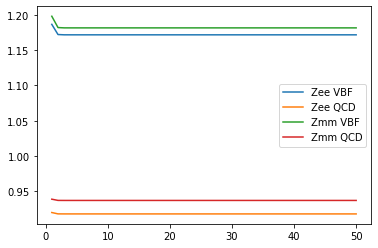

In [38]:
iterations_vector = [i for i in range(1,n_iterations+1)]
plt.plot(iterations_vector,Zee.vbf_factors,label="Zee VBF")
plt.plot(iterations_vector,Zee.qcd_factors,label="Zee QCD")
plt.plot(iterations_vector,Zmm.vbf_factors,label="Zmm VBF")
plt.plot(iterations_vector,Zmm.qcd_factors,label="Zmm QCD")
plt.legend()


In [39]:

for i in final_states:
    print(i.final_state)
    for r in i.regions:
        print(r)
        print(i.dic_of_parameters[r])
    print("VBF = ",i.vbf_factors[n_iterations-1])
    print("QCD = ",i.qcd_factors[n_iterations-1])
    print("\n")  
            
print("SR")       
print(reweight_function)



Zee
CRc
{'m': [-0.0004099035629307711, 6.642534272712725e-05], 'c': [1.1870391760178889, 0.04988016844985746]}
CRa
{'m': [-0.00021524674082846652, 3.368385580921086e-05], 'c': [1.1003754340530778, 0.03421693750511205]}
CRb
{'m': [-0.0001978214199636022, 7.545555344530818e-05], 'c': [0.9714680906414884, 0.05829115982414258]}
SR
{'m': [-0.00044601037638420803, -0.00019757828014595134], 'c': [1.3445513662586468, 0.10700008474280309]}
VBF =  1.1717816478788707
QCD =  0.9178688432532497


Zmumu
CRc
{'m': [-0.0003921538574824948, 5.021905464010248e-05], 'c': [1.2160632871425732, 0.038872165222646686]}
CRa
{'m': [-0.0002640218870928363, 3.7938896792915585e-05], 'c': [1.0945200844039336, 0.04537469833624686]}
CRb
{'m': [-0.0002885358847086262, 2.8444297254273124e-05], 'c': [1.0267093570694381, 0.025420816996429875]}
SR
{'m': [-0.00035883648090364565, -7.760008982124681e-05], 'c': [1.296380209763488, 0.07507207815421776]}
VBF =  1.1816306452512002
QCD =  0.9369771904968405


SR
{'m': -0.0003704